# Dog and Cat Classification using Pre-trained Resnet50

____

## Objective: 
    - This is a project using jupyter notebook to classify the images of the dogs and cats using Resnet50. 
    - The dataset is provided from Kaggle.

## Summary:
- These are the steps we took in this project:
    00. Configuration and Definition
    01. Data analysis
    02. Define the model
    03. Define the Training and Validate the model
    04. Generation of Predictions
    05. Predict the class of any image

___

### Set your folder to this format:

    Project folder
    ├── _cat_dog_project.ipynb
    │
    ├── _data
    │   ├── _train
    │   │   ├── _dog
    │   │   │   └── images(jpg)
    │   │   └── _cat
    │   │       └── images(jpg)
    │   │
    │   └── _val
    │       ├── dog
    │       │   └── images(jpg)
    │       └── _cat
    │           └── images(jpg)
    │    
    │
    └── _test_dataset
        ├── _dog
        │   └── images for testing (jpg)
        └── _cat
            └── images for testing (jpg)


### Number of the data used in this project

- Number of data for each dataset:
    - Training set:
        - Dog: 10017
        - Cat: 9983

    - Validation set:
        - Dog: 2483 
        - Cat: 2517
    
    - Testing set:
        - Dog: 2 (put more yourself or run train_test_split to 60%, 20% and 20%)
        - Cat: 1

### Labels legend:

Labels = [0, 1]
- cat, if class = 0
- dog, if class = 1

____

## 00. Configuration and Definition

In [1]:
# import the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, os.path
import shutil
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
from torchvision import models
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import statistics as st

In [2]:
# hyperparameters

LEARNING_RATE = 0.01
EPOCH_NUM = 30
TRAIN_BATCH_SIZE = 64 #IMPORTANT
VAL_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
print('Processor: ',device)

Processor:  cpu


In [3]:
# paths

path_orig = "data/"

train_d = "data/train/"
ds_dog_tr = "data/train/dog/"
ds_cat_tr = "data/train/cat/"

val_d = "data/val/"
ds_dog_val = "data/val/dog/"
ds_cat_val = "data/val/cat/"

test_d = "data/test/"

___

## 01. Data preparation

In [4]:
# Setup the images into the right folder structure
# Separate the dogs image and cats image - Training

for path in os.listdir(train_d):
    if "cat" in path:
        shutil.move(os.path.join(train_d, path),ds_cat_tr)
    elif "dog" in path:
        shutil.move(os.path.join(train_d, path),ds_dog_tr)

In [5]:
# Separate the dogs image and cats image - Validation

for path in os.listdir(val_d):
    if "cat" in path:
        shutil.move(os.path.join(val_d, path),ds_cat_val)
    elif "dog" in path:
        shutil.move(os.path.join(val_d, path),ds_dog_val)

In [6]:
# Do the train test split of training dataset

dataset = ImageFolder(root=train_d)
train_data, val_data, train_label, val_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)


#### After organizing the folder, apply the train_test_split()

In [7]:
# ImageLoader changes the dimension order and does come configurations to put into DataLoader

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
     
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset): #select only the rgb images
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB



In [8]:
# load the images with ImageLoader class

train_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) 

val_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) 

train_dataset = ImageLoader(train_data, train_transform) #tuple of tensor
val_dataset = ImageLoader(val_data, val_transform)

In [9]:
# Put the images to the DataLoader to pass through 

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)

___

## 02. Declare the model

In [10]:
# import the model and apply

model = models.resnet50(pretrained=True) #resnet50

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) #choose the number of classes here

model.to(device)

/Users/mariotsato/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mariotsato/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

___

## 03. Define the Training and Validate the model

In [12]:
# Train and test

def train(num_epoch, model):
    train_losses = []
    for epoch in range(0, num_epoch):
        loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            loss = criterion(scores, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loop.set_description(f"Epoch {epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())

        train_losses.append(loss.data.item())
        
    # save model
    torch.save({ 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                }, 'checkpoint_epoch_'+str(epoch+1)+'.pt')

    #plot the train loss graph
    plt.figure(figsize=(10,5))
    plt.title('Training Loss')
    plt.plot(train_losses,label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('train_loss.png')
    plt.show()
    print('\n')


In [13]:
# function to validade the accuracy of the trained model
        
def val():
    model.eval()
    test_loss = 0
    correct = 0
    avg_list = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            avg_list.append(float(test_loss))
            
    avg_loss = st.mean(avg_list)
    print("Validation dataset -> Average Loss: ", avg_loss, "  Accuracy: ", correct, " / ",
    len(val_loader.dataset), "  ", int(correct / len(val_loader.dataset) * 100), "%")


Epoch 30/30 process: 99: 100%|███| 250/250 [48:43<00:00, 11.69s/it, loss=0.0649]


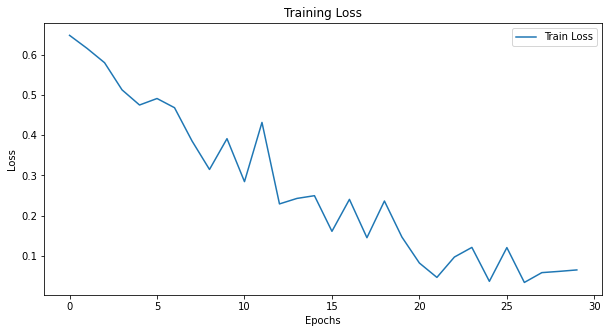



Validation dataset -> Average Loss:  0.557684662355126   Accuracy:  3433  /  4000    85 %


In [14]:
if __name__ == "__main__":
    train(EPOCH_NUM, model) # train
    val() # validation

___

## 04. Generation of Predictions

In [26]:
# load the savedata weights

print("----> Loading checkpoint")
checkpoint = torch.load("./checkpoint_epoch_"+str(EPOCH_NUM)+".pt") # Try to load last checkpoint
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
print("----> Checkpoint "+str(EPOCH_NUM)+" loaded!")

----> Loading checkpoint
----> Checkpoint 30 loaded!


In [27]:
# Set the testing dataset to the format of the torch tensor
dataset = ImageFolder(test_d, 
                     transform=transforms.Compose([
                         transforms.Resize((224, 224)), 
                         transforms.ToTensor(), 
                         transforms.Normalize([0.5]*3, [0.5]*3)
                     ]))

# insert the data to DataLoader
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


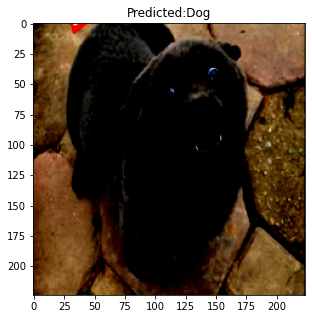

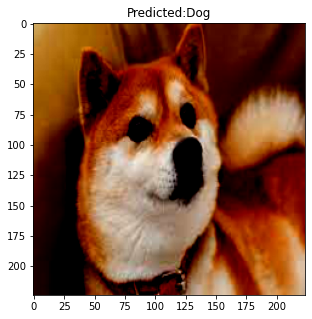

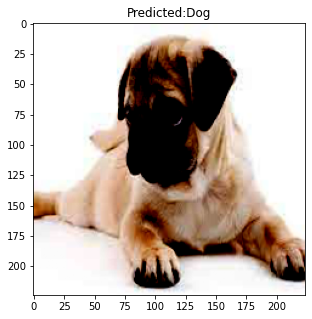

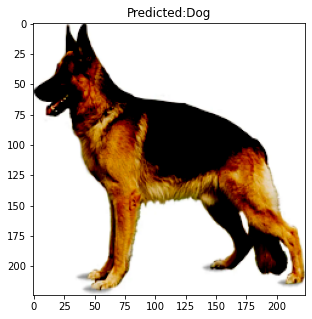

In [28]:
# predict the labels

with torch.no_grad():
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = torch.argmax(output, dim=1)
        #print(f"predicted ----> {predicted[0]}")
        
        # plot images 
        if predicted[0] == 0:
            animal = "Cat"
        elif predicted[0] == 1:
            animal = "Dog"
        img = data
        img = np.reshape(img,(3,224,224))
        img = img.permute(1,2,0)
        plt.figure(figsize=(10,5))
        plt.title("Predicted:"+str(animal))
        plt.imshow(img)


____

## 05. Predict the class of any image

In [29]:
# make a function to generate the predictions

def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) # Returns a new tensor with a dimension of size one inserted at the specified position.
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        preds = torch.argmax(output, dim=1)
        print(f"class : {int(preds)}")
        if preds[0] == 1: print(f"Predicted ----> Dog")
        else: print(f"Predicted ----> Cat")

In [30]:
# Predict any image using this function:
path_test = os.path.join(test_d, "dog/")
for img in os.listdir(path_test):
    if "jpg" in img:
        RandomImagePrediction(os.path.join(path_test,img)) # dog image

class : 1
Predicted ----> Dog
class : 1
Predicted ----> Dog
class : 1
Predicted ----> Dog


### End of the notebook

References: Kaggle datasets and codes.

Feel free to use this code. 
Visit my website and github --> https://mariotsato.github.io and https://github.com/mariotsato